In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, Add, MaxPool3D, Dense, GlobalAveragePooling3D
from keras.models import load_model
import nibabel as nib
from scipy import ndimage

In [2]:
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = tf.keras.layers.Conv3D(filters=squeeze_filters, kernel_size=1, activation='relu', padding='same')(x)
    expand_1x1 = tf.keras.layers.Conv3D(filters=expand_filters, kernel_size=1, activation='relu', padding='same')(squeeze)
    expand_3x3 = tf.keras.layers.Conv3D(filters=expand_filters, kernel_size=3, activation='relu', padding='same')(squeeze)
    expand = tf.keras.layers.Concatenate()([expand_1x1, expand_3x3])
    return expand

def SqueezeNet(input_shape=(64, 64, 3), num_classes=2):
    input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(input)
    x = tf.keras.layers.MaxPooling3D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = tf.keras.layers.MaxPooling3D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = tf.keras.layers.MaxPooling3D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv3D(filters=num_classes, kernel_size=1, activation='relu', padding='valid')(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    output = tf.keras.layers.Activation('softmax')(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model

def load_and_preprocess_image(path):
    # load the .nii.gz file
    img = nib.load(path)

    # get the image data and header
    img_data = img.get_fdata()
    img_header = img.header

    # resize the image to (96, 96, 96)
    img_resized = ndimage.zoom(img_data, (96 / img_data.shape[0], 96 / img_data.shape[1], 96 / img_data.shape[2]), order=1)

    # convert the image to an array and normalize it
    img_array = np.asarray(img_resized, dtype=np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    img_array_norm = (img_array - img_min) / (img_max - img_min)

    return img_array_norm


In [3]:
# Define paths to image directory and label csv file
image_dir = 'Abide_Data'
label_file = 'abide_label_niigz.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [4]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [6]:
# Create the model
model = SqueezeNet(input_shape=(96,96,96,1),num_classes=2)
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.005)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 48, 48, 48,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 23, 23, 23,   0           ['conv3d_1[0][0]']               
                                64)                                                           

In [7]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_model_squeezenet_abide.h5', save_best_only=True, monitor='val_loss')
# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/20
3/3 [==============================] - 109s 29s/step - loss: 0.7005 - accuracy: 0.4211 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 2/20
3/3 [==============================] - 96s 28s/step - loss: 0.6931 - accuracy: 0.4474 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 3/20
3/3 [==============================] - 96s 28s/step - loss: 0.6931 - accuracy: 0.4474 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 4/20
3/3 [==============================] - 99s 29s/step - loss: 0.6931 - accuracy: 0.4474 - val_loss: 0.6931 - val_accuracy: 0.4500


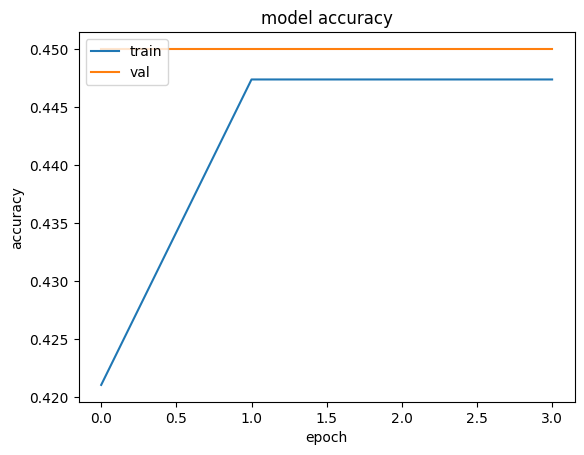

In [8]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

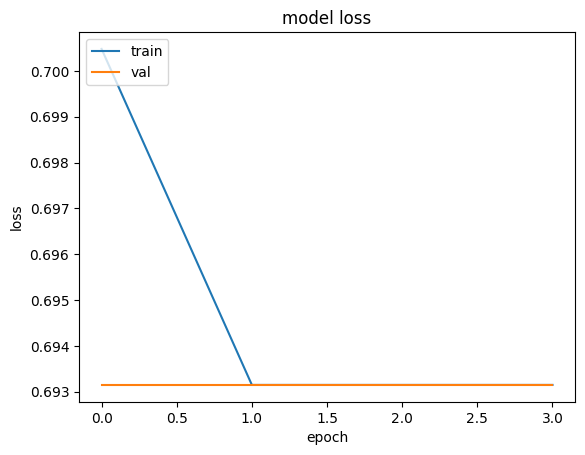

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
best_model = load_model('best_model_squeezenet_abide.h5')

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.6250
Test loss: 0.6931471824645996
Test accuracy: 0.625


In [11]:
result = model.predict(test_images,)
y_test = np.argmax(result, axis=1)

1/1 [==============================] - 4s 4s/step


In [12]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[15  0]
 [ 9  0]]


In [13]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  15
True Negatives (TN):  0
False Positives (FP):  9
False Negatives (FN):  0
Class 2
True Positives (TP):  0
True Negatives (TN):  15
False Positives (FP):  0
False Negatives (FN):  9


In [14]:
from sklearn.metrics import classification_report

# Get the classification report
cr = classification_report(y_true, y_pred, digits=4)

print(cr)

              precision    recall  f1-score   support

           0     0.6250    1.0000    0.7692        15
           1     0.0000    0.0000    0.0000         9

    accuracy                         0.6250        24
   macro avg     0.3125    0.5000    0.3846        24
weighted avg     0.3906    0.6250    0.4808        24



c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abhay Gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  